# Load data

In [5]:
import shap  # https://github.com/slundberg/shap
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
# Load and split data
X_train, X_test, Y_train, Y_test = train_test_split(
    *shap.datasets.adult(), test_size=0.2, random_state=7)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=0)

# Data scaling
num_features = X_train.shape[1]
feature_names = X_train.columns.tolist()
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train.values)
X_val = ss.transform(X_val.values)
X_test = ss.transform(X_test.values)

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


# Train model

In [9]:
import pickle
import os.path
import lightgbm as lgb

In [10]:
if os.path.isfile('census model.pkl'):
    print('Loading saved model')
    with open('census model.pkl', 'rb') as f:
        model = pickle.load(f)

else:
    # Setup
    params = {
        "max_bin": 512,
        "learning_rate": 0.05,
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": "binary_logloss",
        "num_leaves": 10,
        "verbose": -1,
        "min_data": 100,
        "boost_from_average": True
    }

    # More setup
    d_train = lgb.Dataset(X_train, label=Y_train)
    d_val = lgb.Dataset(X_val, label=Y_val)

    # Train model
    model = lgb.train(params, d_train, 10000, valid_sets=[d_val],
                      early_stopping_rounds=50, verbose_eval=1000)
    
    # Save model
    with open('census model.pkl', 'wb') as f:
        pickle.dump(model, f)

Loading saved model


In [11]:
from sklearn import metrics

def get_evaluate(y_test, predict):

    fpr, tpr, thr_arr = metrics.roc_curve(y_test, predict)

    auc = metrics.auc(fpr, tpr)
    precision = metrics.precision_score(y_test, predict)
    recall = metrics.recall_score(y_test, predict)      

    return auc, precision, recall

predict_proba = model.predict(X_test, num_iteration=model.best_iteration)
predict = [0 if i < 0.5 else 1 for i in predict_proba]

get_evaluate(Y_test, predict)

(0.7971318020312249, 0.7868217054263565, 0.6498079385403329)

# Train surrogate

In [12]:
import torch
import torch.nn as nn
from fastshap.utils import MaskLayer1d
from fastshap import Surrogate, KLDivLoss

In [13]:
print( torch.__version__ )

2.0.1+cpu


In [14]:
# Select device
device = torch.device('cpu')

In [38]:
ppp = model.predict(X_val)
print(ppp)
np.stack([1 - ppp, ppp]).T

[6.39857584e-02 9.66003098e-02 3.85090529e-04 ... 3.96895340e-01
 7.56384233e-02 3.13582974e-04]


array([[9.36014242e-01, 6.39857584e-02],
       [9.03399690e-01, 9.66003098e-02],
       [9.99614909e-01, 3.85090529e-04],
       ...,
       [6.03104660e-01, 3.96895340e-01],
       [9.24361577e-01, 7.56384233e-02],
       [9.99686417e-01, 3.13582974e-04]])

In [15]:
# Check for model
if os.path.isfile('census surrogate.pt'):
    print('Loading saved surrogate model')
    surr = torch.load('census surrogate.pt').to(device)
    surrogate = Surrogate(surr, num_features)

else:
    # Create surrogate model
    surr = nn.Sequential(
        MaskLayer1d(value=0, append=True),
        nn.Linear(2 * num_features, 128),
        nn.ELU(inplace=True),
        nn.Linear(128, 128),
        nn.ELU(inplace=True),
        nn.Linear(128, 2)).to(device)

    # Set up surrogate object
    surrogate = Surrogate(surr, num_features)

    # Set up original model
    def original_model(x):
        pred = model.predict(x.cpu().numpy())
        pred = np.stack([1 - pred, pred]).T
        return torch.tensor(pred, dtype=torch.float32, device=x.device)

    # Train
    surrogate.train_original_model(
        X_train,
        X_val,
        original_model,
        batch_size=64,
        max_epochs=100,
        loss_fn=KLDivLoss(),
        validation_samples=10,
        validation_batch_size=10000,
        verbose=True)

    # Save surrogate
    surr.cpu()
    torch.save(surr, 'census surrogate.pt')
    surr.to(device)

Loading saved surrogate model


In [16]:
surrogate.surrogate.eval()

Sequential(
  (0): MaskLayer1d()
  (1): Linear(in_features=24, out_features=128, bias=True)
  (2): ELU(alpha=1.0, inplace=True)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0, inplace=True)
  (5): Linear(in_features=128, out_features=2, bias=True)
)

# Train FastSHAP

In [17]:
from fastshap import FastSHAP

In [18]:
# Check for model
if os.path.isfile('census explainer.pt'):
    print('Loading saved explainer model')
    explainer = torch.load('census explainer.pt').to(device)
    fastshap = FastSHAP(explainer, surrogate, normalization='additive',
                        link=nn.Softmax(dim=-1))

else:
    # Create explainer model
    explainer = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 2 * num_features)).to(device)

    # Set up FastSHAP object
    fastshap = FastSHAP(explainer, surrogate, normalization='additive',
                        link=nn.Softmax(dim=-1))

    # Train
    fastshap.train(
        X_train,
        X_val[:100],
        batch_size=32,
        num_samples=32,
        max_epochs=200,
        validation_samples=128,
        verbose=True)
    
    # Save explainer
    explainer.cpu()
    torch.save(explainer, 'census explainer.pt')
    explainer.to(device)

Loading saved explainer model


# Compare with KernelSHAP

In [19]:
import matplotlib.pyplot as plt

In [20]:
# Setup for KernelSHAP
def imputer(x, S):
    x = torch.tensor(x, dtype=torch.float32, device=device)
    S = torch.tensor(S, dtype=torch.float32, device=device)
    pred = surrogate(x, S).softmax(dim=-1)
    return pred.cpu().data.numpy()

In [21]:
# Select example
ind = np.random.choice(len(X_test))
x = X_test[ind:ind+1]
y = int(Y_test[ind])

# Run FastSHAP
fastshap_values = fastshap.shap_values(x)[0]

# Run KernelSHAP to convergence
game = shapreg.games.PredictionGame(imputer, x)
shap_values, all_results = shapreg.shapley.ShapleyRegression(
    game, batch_size=32, paired_sampling=False, detect_convergence=True,
    bar=True, return_all=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


In [27]:
Y_test

array([False,  True, False, ..., False, False, False])

In [31]:
print(ind)
X_test[ind:ind+1]

2340


array([[-0.63233563,  0.08586467,  1.13117129, -0.40049682, -0.6135913 ,
         0.856581  ,  0.39170454,  0.70314024, -0.14493882, -0.21846582,
         2.38987639,  0.29183004]])

In [30]:
fastshap.shap_values(x)

array([[[ 0.09271204, -0.0943637 ],
        [-0.00419231,  0.00579935],
        [-0.20717722,  0.2094131 ],
        [-0.0876115 ,  0.08756159],
        [ 0.00339084, -0.00487816],
        [-0.08255701,  0.08130698],
        [-0.00370611,  0.00270407],
        [-0.02125033,  0.01954361],
        [ 0.03650542, -0.03509568],
        [ 0.02408466, -0.02117747],
        [-0.06498532,  0.06103707],
        [-0.00534128,  0.00827725]]], dtype=float32)

In [29]:
shap_values.values

array([[ 0.09738295, -0.09738296],
       [-0.00760297,  0.00760296],
       [-0.19919967,  0.19919966],
       [-0.09680066,  0.09680063],
       [ 0.00477108, -0.00477109],
       [-0.08600094,  0.08600093],
       [-0.00458113,  0.00458113],
       [-0.02237598,  0.02237597],
       [ 0.04490557, -0.04490558],
       [ 0.02530626, -0.02530625],
       [-0.07126154,  0.07126154],
       [-0.00467109,  0.00467109]])

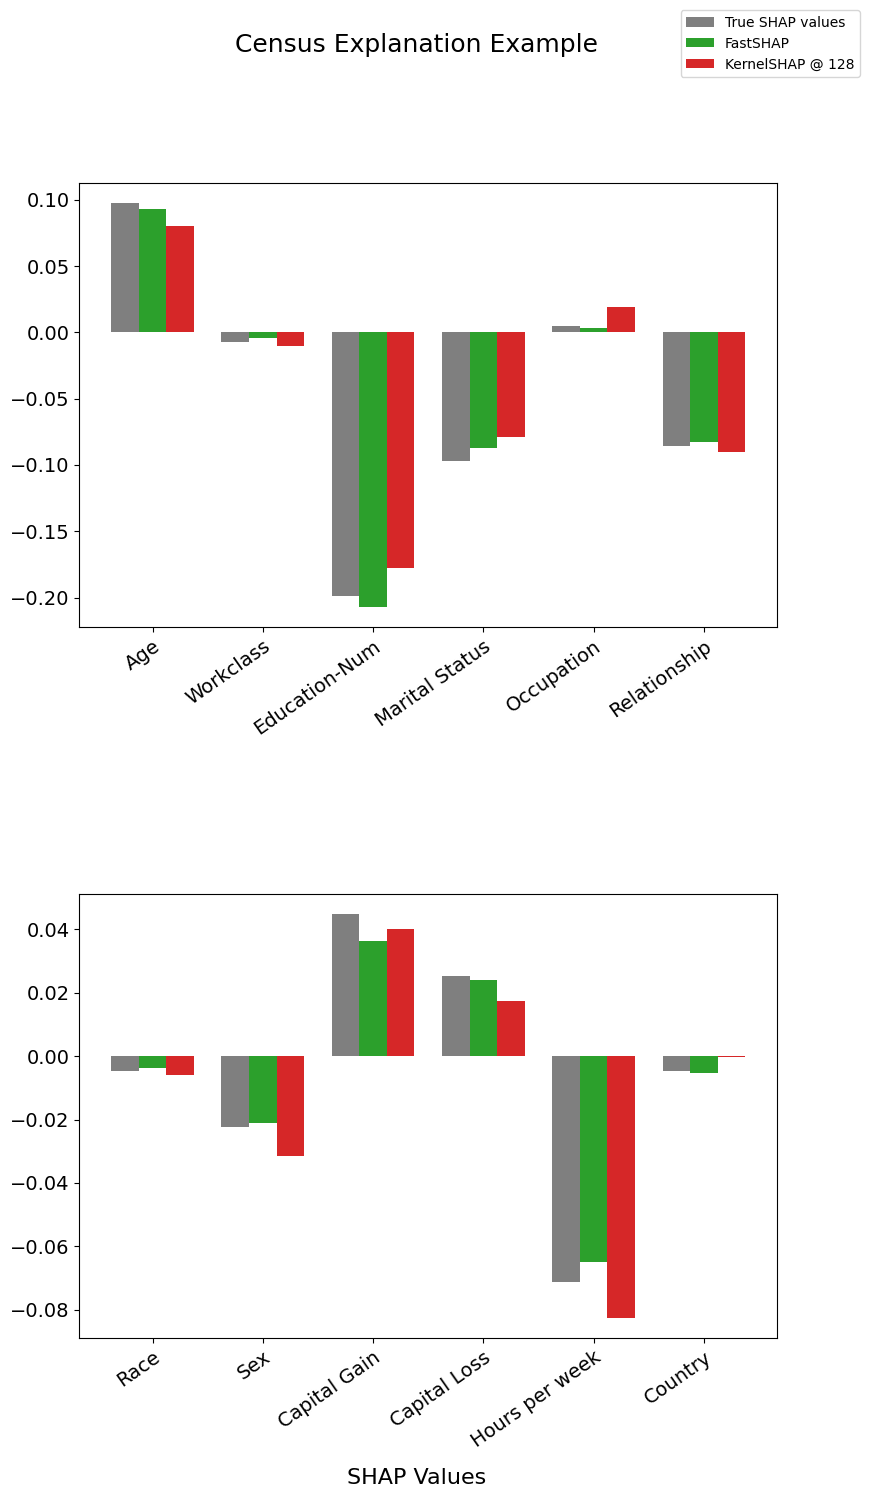

In [87]:
# Create figure
# plt.figure(figsize=(9, 5.5))

ele_per_fig = 6
nrow = (num_features // ele_per_fig) + int((num_features % ele_per_fig) > 0)
ncol = 1
fig, axs = plt.subplots(nrow, ncol, figsize=(9, 15))

# Bar chart
width = 0.75
kernelshap_iters = 128

for idx, ax in enumerate(axs):
    sli = slice(idx*ele_per_fig, (idx+1)*ele_per_fig)
    num_in_row = len(feature_names[sli])

    ax.bar(np.arange(num_in_row) - width / 3, shap_values.values[sli, y],
            width / 3, label='True SHAP values', color='tab:gray')
    ax.bar(np.arange(num_in_row), fastshap_values[sli, y],
            width / 3, label='FastSHAP', color='tab:green')
    ax.bar(np.arange(num_in_row) + width / 3,
            all_results['values'][list(all_results['iters']).index(kernelshap_iters)][sli, y],
            width / 3, label='KernelSHAP @ {}'.format(kernelshap_iters), color='tab:red')
    ax.tick_params(labelsize=14)
    ax.set_xticks(np.arange(ele_per_fig)) 
    ax.set_xticklabels(feature_names[sli] + [""] * (ele_per_fig - num_in_row),
               rotation=35, rotation_mode='anchor', ha='right')

# Annotations
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor = (1, 1),)
fig.supxlabel('SHAP Values', fontsize=16)
fig.suptitle('Census Explanation Example', fontsize=18)
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# plt.tight_layout()
plt.show()